# Modeling

Frequently used libraries are imported.
The dataset imported from the csv file.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from bokeh.plotting import figure, show, output_notebook, output_file, reset_output
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
import osmnx as ox
import geopandas as gpd
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.preprocessing import StandardScaler, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import re

In [40]:
real_estate=pd.read_csv('../Datasets/Real_Estate_Sales_2001-2020_GL.csv')
real_estate.sample(10)

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_79177/1343657660.py:1: DtypeWarning: Columns (8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate=pd.read_csv('../Datasets/Real_Estate_Sales_2001-2020_GL.csv')


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
980033,190286,2019,03/05/2020,Wallingford,1163-20 OLD COLONY RD,135800.0,200000.0,0.679000,Condo,Condo,NaN,NaN,NaN,NaN
402852,50347,2005,06/19/2006,Watertown,63 CANNON RDG,131700.0,255000.0,0.516471,NaN,NaN,NaN,NaN,NaN,NaN
977503,190177,2019,03/27/2020,East Lyme,245 UPPER PATTAGANSETT RD,223580.0,342000.0,0.653700,Single Family,Single Family,04 - Correcting Deed,NaN,NaN,NaN
633444,120457,2012,07/12/2013,Meriden,8 SO VIEW ST,75390.0,131900.0,0.571569,Single Family,Single Family,NaN,NaN,NaN,NaN
890430,170018,2017,11/01/2017,Windham,122 HIGHLAND VIEW DR,112570.0,190000.0,0.592400,Single Family,Single Family,NaN,NaN,NaN,NaN
315738,40421,2004,09/08/2005,Rocky Hill,25 RACHEL DR,22380.0,350400.0,0.063870,NaN,NaN,7.0,NaN,NaN,POINT (-72.63587 41.65099)
67411,90059,2009,02/02/2010,Wilton,27 CANNON ROAD,1385790.0,1650000.0,0.839873,NaN,NaN,NaN,NaN,NaN,NaN
445319,70216,2007,04/30/2008,East Haven,140 THOMPSON ST #19C,108500.0,138000.0,0.786232,Condo,Condo,NaN,NaN,NaN,NaN
978309,190728,2019,05/21/2020,Danbury,20 E PEMBROKE RD 46,97800.0,140000.0,0.698600,Condo,Condo,NaN,I09028-46,NaN,NaN
346360,50213,2005,01/09/2006,Naugatuck,175 CHURCH ST,625040.0,1650000.0,0.378812,NaN,NaN,NaN,NaN,NaN,NaN


Since the columnn `location` is in a string datatype in `POINT (XX.XXXXXX, XX.XXXXX)` format, it will be divided into two columns of the float datatype. 

First, use Regular Expression to find the two floats that might be negative.

In [41]:


def extract_coordinates(location):
    if isinstance(location, str):
        match = re.search(r'\((-?\d+\.\d+)\s(-?\d+\.\d+)\)', location)
        if match:
            return match
    return None


##### Explanation of the regex search:
- `re.search`` matches the characters search literally (case sensitive)

This regex Capturing Group is repeated twice to find the coordinats in the string column of `location`: 
> \((-?\d+\.\d+)\s <

- `?` matches the previous token (which is `-`) between zero and one times, as many times as possible, giving back as needed (greedy). As a result, it preserves the minus sign, indicating that the number could be negative.
- `\d` matches a digit (equivalent to [0-9])
- `+` matches the previous token (which is a digit) between one and unlimited times, as many times as possible, giving back as needed (greedy). As a result, it preserves all the digits.
- `\.` matches the character which the period `.`
- `\d` matches a digit (equivalent to [0-9])
- `+` matches the previous token (which is a digit) between one and unlimited times, as many times as possible, giving back as needed (greedy)
- `\s` matches any whitespace character.

Reference: Used the built-in explanation on https://regex101.com.



In [42]:
#The first group is the latitude
def extract_latitude(coordinates):
    if coordinates is not None:
        return coordinates[1]
    return None

#The second group is the longitude
def extract_longitude(coordinates):
    if coordinates is not None:
        return coordinates[2]
    return None

In [43]:
# Apply the extract_latitude and extract_longitude function

real_estate['coordinates'] = real_estate['Location'].apply(extract_coordinates)
real_estate['latitude'] = real_estate['coordinates'].apply(extract_latitude)
real_estate['longitude'] = real_estate['coordinates'].apply(extract_longitude)

# Convert latitude and longitude columns to numeric types
real_estate['latitude'] = pd.to_numeric(real_estate['latitude'])
real_estate['longitude'] = pd.to_numeric(real_estate['longitude'])

real_estate.sample(10)

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,coordinates,latitude,longitude
350175,50300,2005,11/22/2005,New Haven,758 LEGION AVE,65380.0,200000.0,0.326900,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
607366,11575,2011,07/10/2012,Fairfield,285 HOYDENS HILL ROAD,350000.0,528000.0,0.662879,Single Family,Single Family,NaN,NaN,NaN,NaN,None,NaN,NaN
911842,180491,2018,04/25/2019,Meriden,335 COOK AVE,101780.0,200000.0,0.508900,Two Family,Two Family,NaN,NaN,NaN,NaN,None,NaN,NaN
682484,130044,2013,12/11/2013,Tolland,23 BARSTOW LANE,204100.0,283000.0,0.721201,Single Family,Single Family,NaN,NaN,NaN,NaN,None,NaN,NaN
108218,10107,2001,10/01/2001,Norwalk,61 NEWTOWN AVE,188300.0,370000.0,0.508919,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
129443,10186,2001,01/24/2002,Windsor,911 POQUONOCK AVE,80920.0,94000.0,0.860851,NaN,NaN,NaN,NaN,NaN,POINT (-72.66611 41.87847),"<re.Match object; span=(6, 26), match='(-72.66...",-72.66611,41.87847
521356,90152,2009,06/30/2010,Monroe,4 WOODLAWN RD,205310.0,232000.0,0.884957,Single Family,Single Family,25 - Other,RE-SALE IN LESS THAN 60 DAYS,NaN,NaN,None,NaN,NaN
143994,21265,2002,09/26/2003,Hamden,375 EVERGREEN AVE,81410.0,200000.0,0.407050,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
217194,32731,2003,01/26/2004,New Haven,87 HOWE ST,64680.0,60000.0,1.078000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
832461,161500,2016,09/25/2017,Norwalk,51 ELMWOOD AVE,216090.0,410026.0,0.527015,Three Family,Three Family,14 - Foreclosure,FORECLOSURE BY SALE,NaN,NaN,None,NaN,NaN


From this output, it is evident that `latitude` and `longitude` columns have the successfully extracted coordinates.

Next, check the datatypes of `latitude` and `longitude`

In [44]:
print(real_estate.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Serial Number     997213 non-null  int64  
 1   List Year         997213 non-null  int64  
 2   Date Recorded     997211 non-null  object 
 3   Town              997213 non-null  object 
 4   Address           997162 non-null  object 
 5   Assessed Value    997213 non-null  float64
 6   Sale Amount       997213 non-null  float64
 7   Sales Ratio       997213 non-null  float64
 8   Property Type     614767 non-null  object 
 9   Residential Type  608904 non-null  object 
 10  Non Use Code      289681 non-null  object 
 11  Assessor Remarks  149864 non-null  object 
 12  OPM remarks       9934 non-null    object 
 13  Location          197697 non-null  object 
 14  coordinates       197696 non-null  object 
 15  latitude          197696 non-null  float64
 16  longitude         19

Change the `Date Recorded` from Object to DateTime.

In [45]:
real_estate['Date Recorded'] = pd.to_datetime(real_estate['Date Recorded'])
real_estate['Date Recorded'].dtype

dtype('<M8[ns]')

In [46]:
real_estate_nonull = real_estate.dropna(subset=['Date Recorded', 'Location', 'longitude'])
real_estate.drop(real_estate[real_estate['OPM remarks'] == 'INCORRECT SALE PRICE'].index, inplace=True)

real_estate_nonull.sample()

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location,coordinates,latitude,longitude
470150,70373,2007,2008-09-04,East Haven,2 LYNWOOD PL,167550.0,236100.0,0.709657,Single Family,Single Family,NaN,NaN,NaN,POINT (-72.86941 41.3018),"<re.Match object; span=(6, 25), match='(-72.86...",-72.86941,41.3018


In [47]:
real_estate['Non Use Code'] = real_estate['Non Use Code'].str.replace(r'[a-zA-Z-]', '')

real_estate['Non Use Code']  = real_estate['Non Use Code'].str.replace(r'0([1-9])\b', r'\1')

real_estate['Non Use Code']  = real_estate['Non Use Code'].str.replace(r'\s', '')



/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_79177/3344978338.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  real_estate['Non Use Code'] = real_estate['Non Use Code'].str.replace(r'[a-zA-Z-]', '')
/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_79177/3344978338.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  real_estate['Non Use Code']  = real_estate['Non Use Code'].str.replace(r'0([1-9])\b', r'\1')
/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_79177/3344978338.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  real_estate['Non Use Code']  = real_estate['Non Use Code'].str.replace(r'\s', '')


In [10]:
real_estate_nonull = real_estate_nonull.drop(columns=['Serial Number', 'Date Recorded', 'Sales Ratio', 'Address', 'Location', 'coordinates','Assessor Remarks'	, 'OPM remarks'], axis=1)
real_estate_nonull.sample()

,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Non Use Code,latitude,longitude
807685,2016,Hamden,158270.0,239000.0,Single Family,Single Family,NaN,-72.92033,41.39311


plotly, tableau map
look for datasets
interest rate


In [48]:
#Missing values check
print(".info of All Columns\n", real_estate_nonull.info())
print("Null Values in Total\n", real_estate_nonull.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197696 entries, 10 to 997206
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Serial Number     197696 non-null  int64         
 1   List Year         197696 non-null  int64         
 2   Date Recorded     197696 non-null  datetime64[ns]
 3   Town              197696 non-null  object        
 4   Address           197691 non-null  object        
 5   Assessed Value    197696 non-null  float64       
 6   Sale Amount       197696 non-null  float64       
 7   Sales Ratio       197696 non-null  float64       
 8   Property Type     126043 non-null  object        
 9   Residential Type  123754 non-null  object        
 10  Non Use Code      54647 non-null   object        
 11  Assessor Remarks  29523 non-null   object        
 12  OPM remarks       2130 non-null    object        
 13  Location          197696 non-null  object        
 14  coo

In [28]:
coded_real_estate = pd.get_dummies(real_estate_nonull, columns=['List Year', 'Town', 'Property Type', 'Residential Type', 'Non Use Code'])

In [29]:
X = coded_real_estate.drop(['Sale Amount', 'Assessed Value'], axis=1)

In [30]:
y = coded_real_estate['Sale Amount']


In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [32]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [33]:
X_train.shape

(158156, 302)

In [34]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

In [35]:
train_scores = []
test_scores = []

ks = list(range(10, 100, 10))

for k in ks: 
    my_KBest = SelectKBest(f_regression, k=k).fit(X_train, y_train)
    
    X_train_selected = my_KBest.transform(X_train)
    X_test_selected = my_KBest.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    print(f"K = {X_train.columns[my_KBest.get_support()]}")

    
    
    train_scores.append(model.score(X_train_selected, y_train))
    test_scores.append(model.score(X_test_selected, y_test))



K = Index(['latitude', 'longitude', 'List Year_2020', 'Town_Darien',
       'Town_Greenwich', 'Town_New Canaan', 'Town_Stamford', 'Town_Westport',
       'Property Type_Apartments', 'Property Type_Commercial'],
      dtype='object')
K = Index(['latitude', 'longitude', 'List Year_2001', 'List Year_2020',
       'Town_Bridgeport', 'Town_Darien', 'Town_Fairfield', 'Town_Greenwich',
       'Town_New Canaan', 'Town_Stamford', 'Town_Waterbury', 'Town_Westport',
       'Town_Wilton', 'Property Type_Apartments', 'Property Type_Commercial',
       'Property Type_Condo', 'Property Type_Residential',
       'Residential Type_Condo', 'Non Use Code_03 - Inter Corporation',
       'Non Use Code_14 - Foreclosure'],
      dtype='object')
K = Index(['latitude', 'longitude', 'List Year_2001', 'List Year_2002',
       'List Year_2020', 'Town_Bridgeport', 'Town_Bristol', 'Town_Darien',
       'Town_Fairfield', 'Town_Greenwich', 'Town_New Britain',
       'Town_New Canaan', 'Town_Norwalk', 'Town_Ridgefield

In [36]:
X_withconstant = sm.add_constant(X_train)

In [37]:
myregression = sm.OLS(y_train, X_withconstant)


In [38]:

myregression_results = myregression.fit()

myregression_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sale Amount   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     29.18
Date:                Fri, 18 Aug 2023   Prob (F-statistic):               0.00
Time:                        01:33:29   Log-Likelihood:            -2.5000e+06
No. Observations:              158156   AIC:                         5.001e+06
Df Residuals:                  157858   BIC:                         5.004e+06
Df Model:                         297                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                        7.523e+06    5.7e+06      1.319      0.187   -3.66e+06    1.87e+07
latitude                                                     4910.2014   3.31e+04      0.148      0.882   -5.99e+04    6.97e+04
longitude                                                   -1.609e+05   1.09e+05     -1.477      0.140   -3.75e+05    5.27e+04
List Year_2001                                              -3.069e+05   2.89e+05     -1.064      0.288   -8.72e+05    2.59e+05
List Year_2002                                              -2.873e+05   2.88e+05     -0.996      0.319   -8.53e+05    2.78e+05
List Year_2003                                              -2.202e+05   2.88e+05     -0.764      0.445   -7.85e+05    3.45e+05
List Year_2004                                              -1.801e+05   2.88e+05     -0.625      0.532   -7.45e+05    3.85e+05
List Year_2005                                              -1.444e+05   2.88e+05     -0.501      0.617    -7.1e+05    4.21e+05
List Year_2006                                               6.125e+05   2.88e+05      2.126      0.033    4.79e+04    1.18e+06
List Year_2007                                               6.069e+05   2.88e+05      2.105      0.035    4.17e+04    1.17e+06
List Year_2008                                               5.496e+05   2.88e+05      1.905      0.057   -1.57e+04    1.11e+06
List Year_2009                                               5.323e+05   2.88e+05      1.847      0.065   -3.27e+04     1.1e+06
List Year_2010                                               5.489e+05   2.88e+05      1.903      0.057   -1.64e+04    1.11e+06
List Year_2011                                               5.302e+05   2.88e+05      1.838      0.066   -3.51e+04     1.1e+06
List Year_2012                                               5.377e+05   2.88e+05      1.865      0.062   -2.74e+04     1.1e+06
List Year_2013                                               6.112e+05   2.88e+05      2.119      0.034    4.59e+04    1.18e+06
List Year_2014                                               5.654e+05   2.88e+05      1.962      0.050     723.119    1.13e+06
List Year_2015                                               5.816e+05   2.88e+05      2.019      0.044    1.69e+04    1.15e+06
List Year_2016                                               6.702e+05   2.88e+05      2.326      0.020    1.05e+05    1.24e+06
List Year_2017                                               6.025e+05   2.88e+05      2.091      0.037    3.76e+04    1.17e+06
List Year_2018                                               5.994e+05   2.88e+05      2.080      0.037    3.47e+04    1.16e+06
List Year_2

In [23]:
for column in (real_estate.columns):
    if (real_estate_nonull[column].isna().sum())== 0:
        pass
        #print (column, " passed")
    else:
        nunique_values = real_estate[column].nunique()
        unique_values = real_estate[column].unique()
        value_counts = real_estate[column].value_counts()
        print(f"The column name is {column}")
        print(f"The total number of unique values are: {nunique_values}")
        print(f"The value counts are: {value_counts}")

KeyError: 'Serial Number'

Findings:
   - `Date` column can be changed to DateTime format
   - `Date Recorded`, `Town`, `Address`, `Assessed Value`, `Sale Amount`, `Sale Ratio` have very few missing values.
   - Address has 51 missingcolumns.
   - About 1/3 of rows missing in `Property Type` and `Residential Type`.
   - About 20% of the data has `Location` or longitude and latitude.
   

/var/folders/kv/4xjj0g696_lcyc7ms5pdd2t00000gn/T/ipykernel_79177/1560488043.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = real_estate.corr()


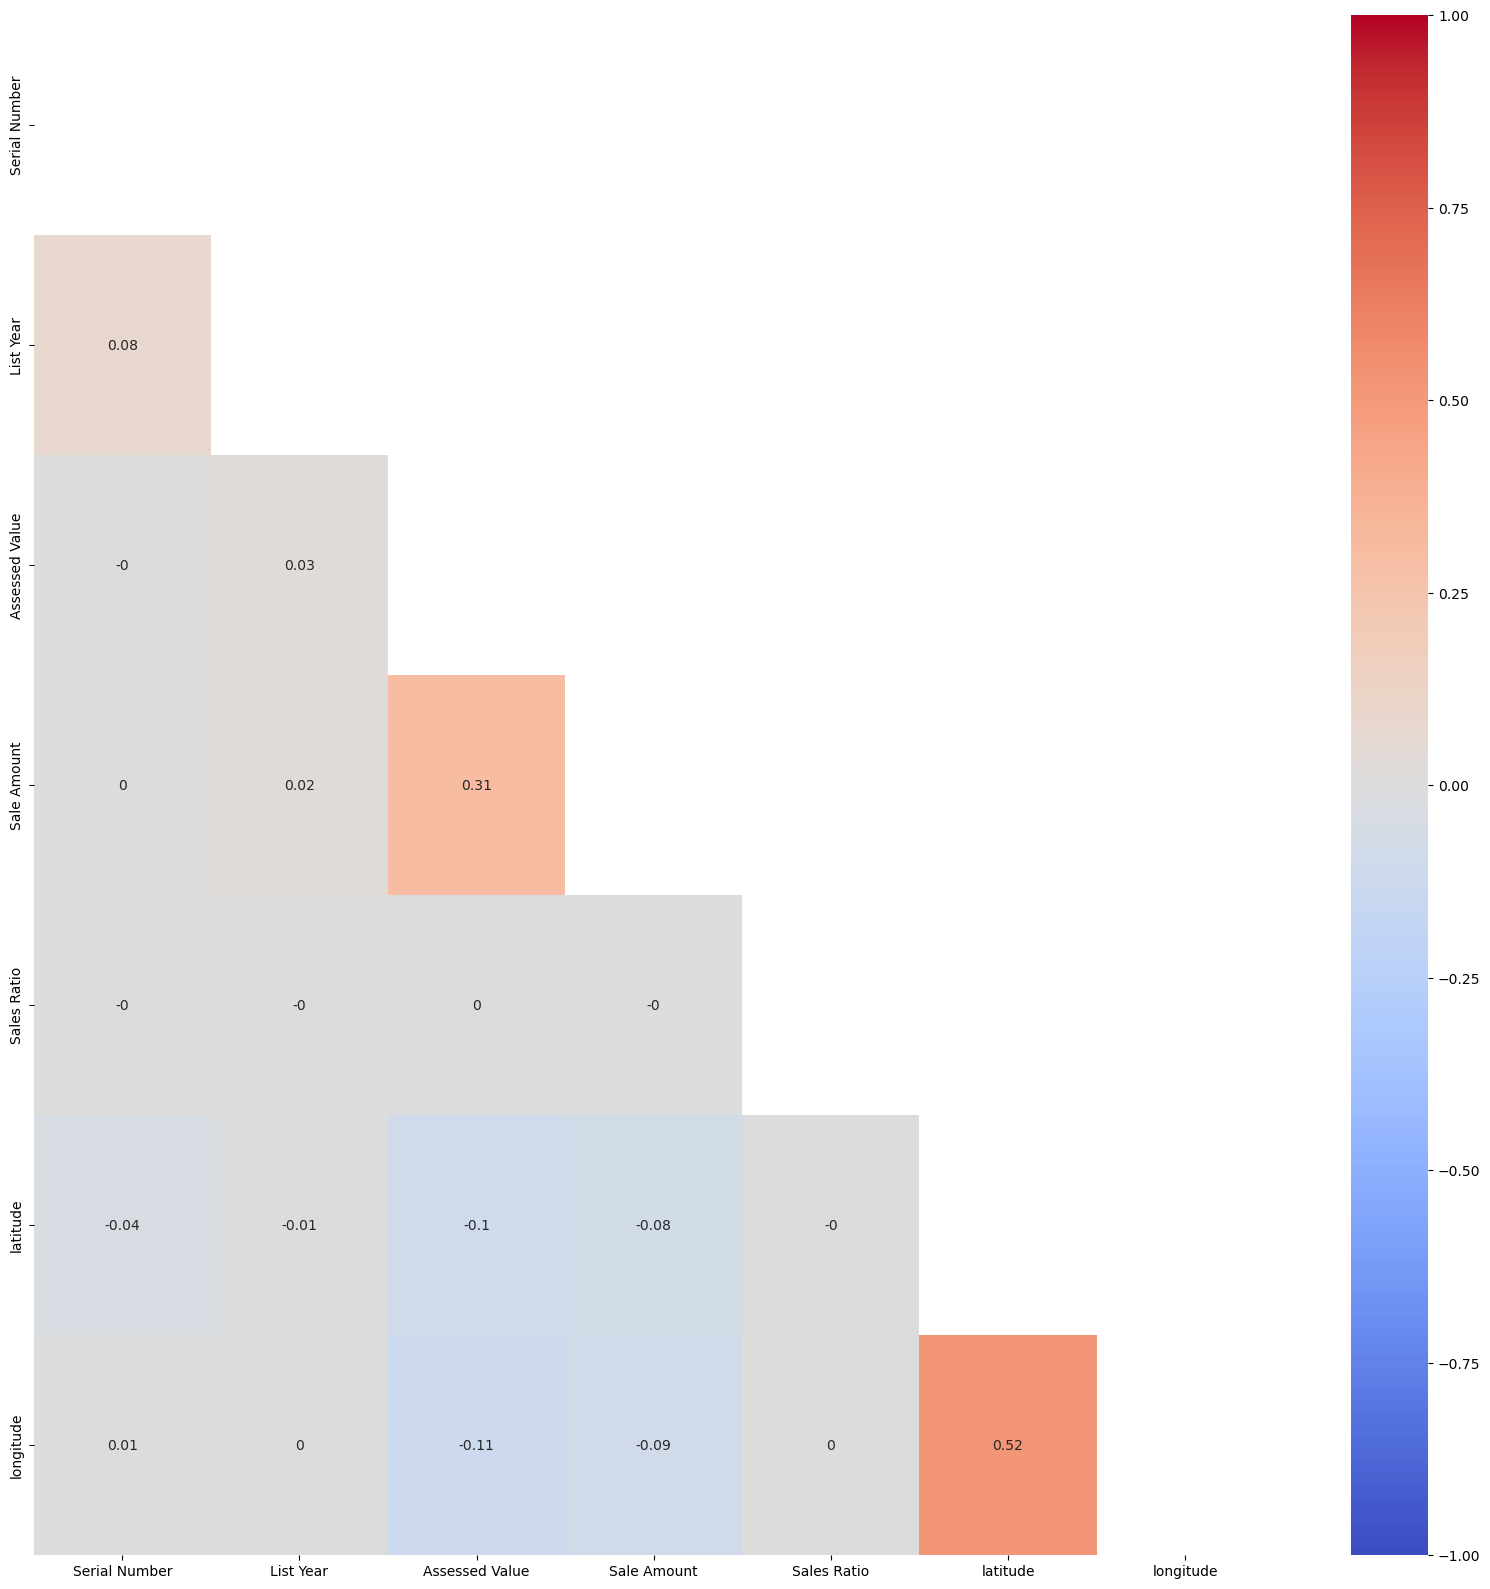

In [25]:
corr_df = real_estate.corr()
mask = np.triu(corr_df)
plt.figure(figsize=(20,20))
sns.heatmap(corr_df.round(2), annot=True,mask=mask, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

Findings:
   - `Assessed Value` and `Sale Amount` is weakly correlated (r=0.11).

In [ ]:
sns.boxplot(x='List Year', y='Sale Amount', data=real_estate)

: 

In the `OPM remarks`, it is stated that an *INCORRECT SALE PRICE* is inserted. So this row will be deleted and will investigate if other rows have the same comment.

: 

: 

In [ ]:
plt.barh(real_estate.groupby('Property Type').mean()["Sale Amount"].index, real_estate.groupby('Property Type').mean()["Sale Amount"])
plt.xticks(rotation=45)
plt.title('Mean Sale Amount by Property Type')


: 

In [ ]:
plt.barh(real_estate.groupby('List Year').mean()['Sale Amount'].index, real_estate.groupby('List Year').mean()["Sale Amount"])
plt.xticks(rotation=45)
plt.title('Mean Sale Amount by List Year')


: 

: 

: 